https://www.kaggle.com/datasets/vetrirah/customer?select=Test.csv

# 0. Описание задачи
## В датасете имеются следующие признаки:
- Age - возраст
- Gender - пол
- Ever_Married - был ли человек когда-либо женат
- Graduated - есть ли образование
- Profession - профессия
- Work_Experience - опыт работы
- Spending_Score - оценка расходов клиента
- Family_Size - размер семьи
- Var_1 - Анонимизированная категория для клиента
- Segmentation - ключевое знаечние - категория клиента?  
Задача связана с маркетинговой кампанией автомобильного диллера. Маркетинговые кампании были основаны на телефонных звонках. 
Нужно на основе данных признаков предсказать, к какой категории относится клиент.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
%matplotlib inline

# 1. Загружаем данные

In [2]:
#data = pd.read_csv('Train_Data.csv', delimiter=',')
data = pd.read_csv('Train.csv', delimiter=',')

In [3]:
type(data)

pandas.core.frame.DataFrame

In [4]:
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [5]:
data.index

RangeIndex(start=0, stop=8068, step=1)

отбрасываем столбец `'ID'`

In [6]:
data = data.drop(columns = 'ID')

In [7]:
for c in data.columns:
    print(data[c].dtype.name)

object
object
int64
object
object
float64
object
float64
object
object


In [8]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']

In [9]:
integer_columns = [c for c in data.columns if data[c].dtype.name == 'int64' or data[c].dtype.name == 'float64']

In [10]:
print(categorical_columns)

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']


In [11]:
print(integer_columns)

['Age', 'Work_Experience', 'Family_Size']


Заменим тип столбцов, содержащих категориальные значения, на специальный.

In [12]:
for c in data.columns:
    if data[c].dtype.name == 'object':
        data[c] = data[c].astype('category')

In [13]:
for c in data.columns:
    print(data[c].dtype.name)

category
category
int64
category
category
float64
category
float64
category
category


### Боремся с выбросами

Удалим все строки таблицы, в которых `'Age'`, `'Work_Experience'` и `'Family_Size'` выходят за пределы квантилей  0.005 ,  0.995 .

In [14]:
print(integer_columns)

['Age', 'Work_Experience', 'Family_Size']


In [15]:
rows_to_drop = data[
    (data['Age'] < data['Age'].quantile(0.005)) | (data['Age'] > data['Age'].quantile(0.995)) | 
    (data['Work_Experience']  < data['Work_Experience' ].quantile(0.005)) | 
    (data['Work_Experience']  > data['Work_Experience' ].quantile(0.995)) | 
    (data['Family_Size']  < data['Family_Size' ].quantile(0.005)) | 
    (data['Family_Size']  > data['Family_Size' ].quantile(0.995))].index
data = data.drop(rows_to_drop)
data.shape

(8032, 10)

In [16]:
print(data['Segmentation'])

0       D
1       A
2       B
3       B
4       A
       ..
8063    D
8064    D
8065    D
8066    B
8067    B
Name: Segmentation, Length: 8032, dtype: category
Categories (4, object): ['A', 'B', 'C', 'D']


# 2. Визуализация данных и вычисление основных характеристики (среднее, разброс, корелляционная матрица)

In [17]:
print(data.columns)

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


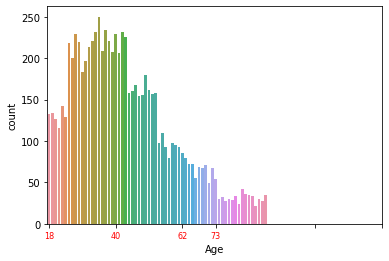

In [18]:
sns.countplot(data=data[['Age']],x='Age')
plt.xticks([0, 20, 40, 50, 80, 100], color="r", size=8)
plt.show()

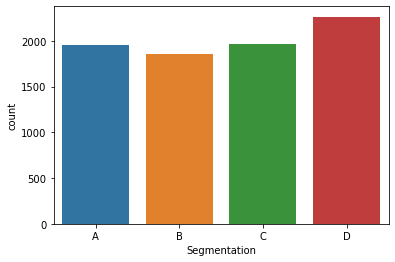

In [19]:
sns.countplot(data=data[['Segmentation']],x='Segmentation')
plt.show()

Для каждого количественного признака приведём среднее значение, стандартное отклонение, минимальное и макимальное значения, медиану и значения квартилей.

In [20]:
data.describe()

,Age,Work_Experience,Family_Size
count,8032.000000,7207.000000,7700.000000
mean,43.262824,2.647149,2.853896
std,16.468072,3.409463,1.532970
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,88.000000,14.000000,9.000000


Построим матрицу корреляций количественных признаков

In [21]:
data.corr()

,Age,Work_Experience,Family_Size
Age,1.000000,-0.189838,-0.278589
Work_Experience,-0.189838,1.000000,-0.064011
Family_Size,-0.278589,-0.064011,1.000000


Для категориальных признаков

In [22]:
data.describe(include=['category'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8032,7893,7955,7908,8032,7956,8032
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4403,4611,4948,2513,4866,5204,2263


Визуализируем корреляцию

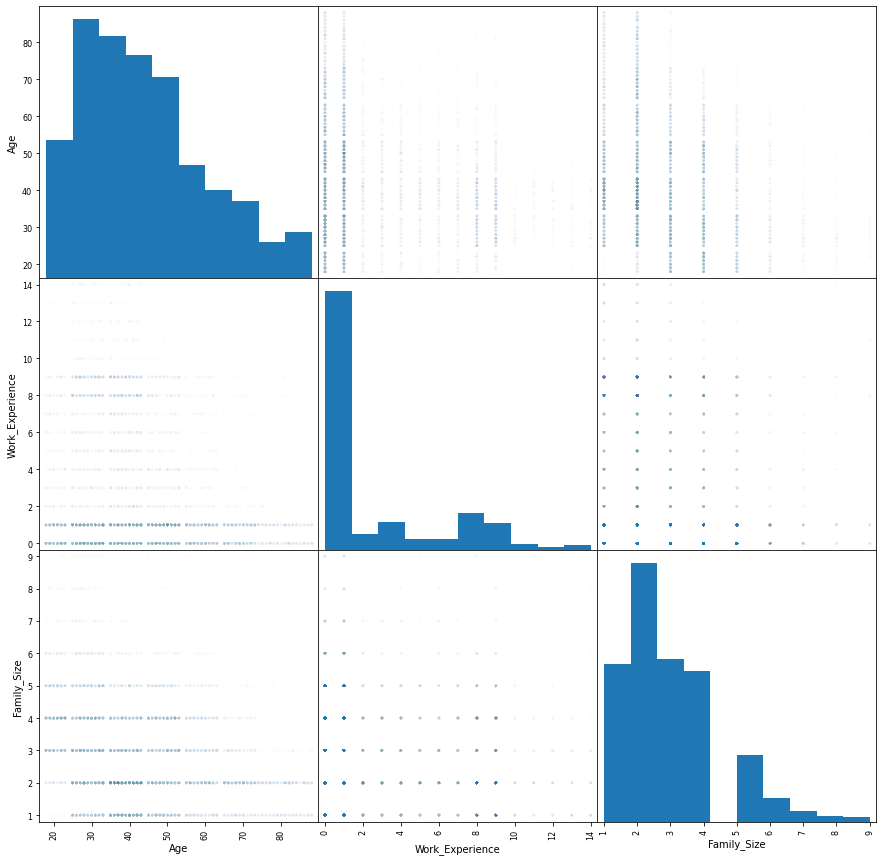

In [23]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (15, 15))
pass

In [24]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)

Построим все возможные диаграммы рассеивания для каждой пары переменных:

No handles with labels found to put in legend.


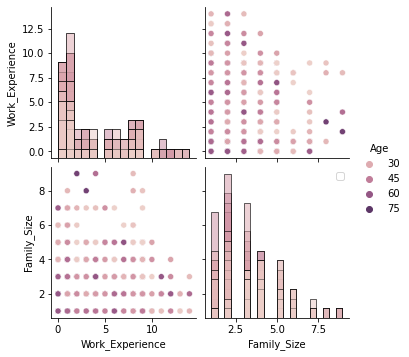

In [25]:
sns.pairplot(data.iloc[random_subset], hue='Age', diag_kind='hist')
plt.legend()
pass

# 3. Обработка пропущенных значений

Считаем количество пропущенных значений

In [26]:
data.isna().sum() 

Gender               0
Ever_Married       139
Age                  0
Graduated           77
Profession         124
Work_Experience    825
Spending_Score       0
Family_Size        332
Var_1               76
Segmentation         0
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [27]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [28]:
data.isna().sum()  

Gender               0
Ever_Married       139
Age                  0
Graduated           77
Profession         124
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1               76
Segmentation         0
dtype: int64

Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:

In [29]:
#data['Credit_Product'].fillna(data['Credit_Product'].mode().iloc[0], inplace=True)
data['Ever_Married'    ].fillna(data['Ever_Married'    ].mode().iloc[0], inplace=True)
data['Graduated'    ].fillna(data['Graduated'    ].mode().iloc[0], inplace=True)
data['Profession'    ].fillna(data['Profession'    ].mode().iloc[0], inplace=True)
data['Var_1'    ].fillna(data['Var_1'    ].mode().iloc[0], inplace=True)

In [30]:
data.isna().sum()  

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [31]:
data.describe()

,Age,Work_Experience,Family_Size
count,8032.000000,8032.000000,8032.000000
mean,43.262824,2.477963,2.859935
std,16.468072,3.268084,1.501231
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,88.000000,14.000000,9.000000


In [32]:
data.describe(include=['category'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8032,8032,8032,8032,8032,8032,8032
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4403,4750,5025,2637,4866,5280,2263


# 4. Обработка категориальных признаков

Бинарные признаки 'Gender', 'Ever_Married' 'Graduated' заменим на числовые.

In [33]:
data['Gender'] = pd.factorize(data['Gender'])[0]
data['Ever_Married'] = pd.factorize(data['Ever_Married'])[0]
data['Graduated'] = pd.factorize(data['Graduated'])[0]
#data['Credit_Product'] = pd.factorize(data['Credit_Product'])[0]
#data['Is_Active'] = pd.factorize(data['Is_Active'])[0]

К категориальным признакам 'Profession', 'Spending_Score', 'Var_1' применим метод бинаризации

In [34]:
print(categorical_columns)

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']


In [35]:
Profession_dummies = pd.get_dummies(data['Profession'])
Spending_Score_dummies = pd.get_dummies(data['Spending_Score'])
Var_1_dummies = pd.get_dummies(data['Var_1'])

Добавим эти dummy-столбцы к таблице и удалим столбцы 'Profession', 'Spending_Score', 'Var_1':

In [37]:
data = pd.concat((data, Profession_dummies, Spending_Score_dummies, Var_1_dummies), axis=1)
data = data.drop(['Profession', 'Spending_Score', 'Var_1'], axis=1)

In [38]:
data.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Segmentation,Artist,Doctor,Engineer,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,0,0,22,0,1.0,4.0,D,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,1,38,1,1.0,3.0,A,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,1,1,67,1,1.0,1.0,B,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,0,1,67,1,0.0,2.0,B,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,1,40,1,1.0,6.0,A,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [39]:
data.to_csv('file_w.csv', header=True, index=False)

# 5. Проведение нормализации

Выполним стандартизацию всех признаков:

In [40]:
data_stand =  data.drop('Segmentation', axis = 1)

In [41]:
data_stand

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Artist,Doctor,Engineer,Entertainment,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,0,0,22,0,1.0,4.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,1,38,1,1.0,3.0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,1,1,67,1,1.0,1.0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,0,1,67,1,0.0,2.0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,1,40,1,1.0,6.0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0,0,22,0,0.0,7.0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8064,0,0,35,0,3.0,4.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8065,1,0,33,1,1.0,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8066,1,0,27,1,1.0,4.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [42]:
data_stand = (data_stand - data_stand.min(axis = 0))/(data_stand.max(axis = 0) - data_stand.min(axis = 0))

In [43]:
data_stand.describe()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Artist,Doctor,Engineer,Entertainment,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
count,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,...,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000
mean,0.451818,0.591384,0.360897,0.625623,0.176997,0.232492,0.328312,0.085533,0.087027,0.118028,...,0.245642,0.148531,0.605827,0.016559,0.052291,0.102341,0.135583,0.010583,0.657371,0.025274
std,0.497704,0.491609,0.235258,0.483992,0.233435,0.187654,0.469628,0.279690,0.281892,0.322661,...,0.430494,0.355648,0.488703,0.127619,0.222627,0.303115,0.342366,0.102333,0.474618,0.156966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.171429,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.314286,1.000000,0.071429,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.500000,1.000000,0.285714,0.375000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
data_stand.to_csv('file_w.csv', header=True, index=False)

# 6. Разбиение данных на обучающую и тестовую выборку

In [47]:
X = data_stand
y = data['Segmentation'] # создаём вектор значений столбца 'Subscription'
feature_names = X.columns

In [48]:
X

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Artist,Doctor,Engineer,Entertainment,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,0.0,0.0,0.057143,0.0,0.071429,0.375,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.285714,1.0,0.071429,0.250,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.700000,1.0,0.071429,0.000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.700000,1.0,0.000000,0.125,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.314286,1.0,0.071429,0.625,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0.0,0.0,0.057143,0.0,0.000000,0.750,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8064,0.0,0.0,0.242857,0.0,0.214286,0.375,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8065,1.0,0.0,0.214286,1.0,0.071429,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8066,1.0,0.0,0.128571,1.0,0.071429,0.375,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
feature_names

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Work_Experience',
       'Family_Size', 'Artist', 'Doctor', 'Engineer', 'Entertainment',
       'Executive', 'Healthcare', 'Homemaker', 'Lawyer', 'Marketing',
       'Average', 'High', 'Low', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5',
       'Cat_6', 'Cat_7', 'Artist', 'Doctor', 'Engineer', 'Entertainment',
       'Executive', 'Healthcare', 'Homemaker', 'Lawyer', 'Marketing',
       'Average', 'High', 'Low', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5',
       'Cat_6', 'Cat_7'],
      dtype='object')

In [50]:
X = X.to_numpy()

In [51]:
Y = np.array(y)
type(Y)

numpy.ndarray

In [52]:
print(X.shape)
print(y.shape)
N, d = X.shape

(8032, 44)
(8032,)


In [53]:
Y

array(['D', 'A', 'B', ..., 'D', 'B', 'B'], dtype=object)

Разбиваем множества на обучающую и тестовую части

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

5622 2410


# 7. Запускаем классификатор ближайших соседей

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [56]:
knn

KNeighborsClassifier()

### Попробуем предсказать значение, используя функцию  predict

In [57]:
number = 56
obj = X_test[number, :]
value = y_test[number]
knn.predict([obj])

array(['D'], dtype=object)

In [58]:
value

'D'

# 8. Вычисление ошибок на обучащей и тестовой выборках

In [59]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [60]:
y_train != y_train_pred

array([ True, False, False, ..., False, False, False])

In [61]:
y_test != y_test_pred

array([False,  True, False, ...,  True,  True, False])

Находим долю ошибок в нашем предсказание

In [62]:
y_test_pred = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_pred)

In [63]:
y_train_pred = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_pred)

In [64]:
err_test, err_train

(0.5410788381742738, 0.36108146567057986)

Находим качество нашего предсказания

In [65]:
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.6389185343294201, 0.4589211618257261)

In [66]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_pred))

[[278 141  83 112]
 [173 157 149  49]
 [ 97 143 266  52]
 [173  80  52 405]]


In [69]:
confusion_matrix([0,1,0,1,0], [0,1,0,0,0])

array([[3, 0],
       [1, 1]], dtype=int64)

# 9. Сравнение с другими методами

## Метод SVC

In [68]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.5124510850231234 0.5058091286307054


# Общие выводы

Таким образом, мы рассмотрели задачу классификации и решение этой задачи с помощью метода "К ближайших соседей". 
Данный метод имеет свои ограничения: неспособность работать с категориальными признаками объекта(требуются дополнительные
преобразования к числовым значениям); необходимость нормализации значений числовых признаков. К плюсам данного алгоритма
можно отнести его простоту и лёгкую реализуемость, к минусам же можно отнести значительное уменьшение скорости работы при
увеличение количества признаков. 
При применении методов к моему датасету получился очень высокий процент ошибки. Скорее всего это связано с тем, что классы слишком сбалансированы относительно друг друга